In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
from torch.optim import Adam
import gymnasium as gym

sns.set(style="darkgrid", context="talk", palette="muted")

from ppo import Feedforward, PPO

# https://www.digitalocean.com/community/tutorials/pytorch-hooks-gradient-clipping-debugging
# https://www.youtube.com/watch?v=bHx8A8tbj2c


# Current Progress

1. Losses doesn't improve after 90'000 steps 
2. I need to plot rewards to get the whole picture

- Explainations: 
  - Network is too shalow and is overfitting 
  - Lerning rate is too high and doesnt decrease enough 

### Improvement 

- Include the entropy in the loss

In [2]:
# Create env, model
env = gym.make("Pendulum-v1")
device = "cpu"                # GPUs is not worth for hidden dim < 256
model = PPO(env)

# Learning
total_timesteps = 500000
history_actor_loss, history_critic_loss = model.learn(total_timesteps) 

Learning Process:
Total timesteps 500000
Timesteps per batch 6000
Max timesteps per episode 2000
Number of backward passes per batch 5
Number of mini batches per pass 5 
 

1 Rollout - Timestep 3200 || Actor loss: 0.0057 | Critic loss: 17741.8700
2 Rollout - Timestep 6400 || Actor loss: -0.0000 | Critic loss: 17520.4635
3 Rollout - Timestep 9600 || Actor loss: 0.0000 | Critic loss: 14904.9434
4 Rollout - Timestep 12800 || Actor loss: 0.0001 | Critic loss: 12523.0968
5 Rollout - Timestep 16000 || Actor loss: 0.0001 | Critic loss: 8671.3871
6 Rollout - Timestep 19200 || Actor loss: 0.0003 | Critic loss: 5579.4757
7 Rollout - Timestep 22400 || Actor loss: 0.0004 | Critic loss: 3202.0725
8 Rollout - Timestep 25600 || Actor loss: -0.0012 | Critic loss: 2372.2506
9 Rollout - Timestep 28800 || Actor loss: 0.0001 | Critic loss: 1616.3299
10 Rollout - Timestep 32000 || Actor loss: -0.0010 | Critic loss: 2160.3715
11 Rollout - Timestep 35200 || Actor loss: -0.0003 | Critic loss: 2142.9602
12 Rol

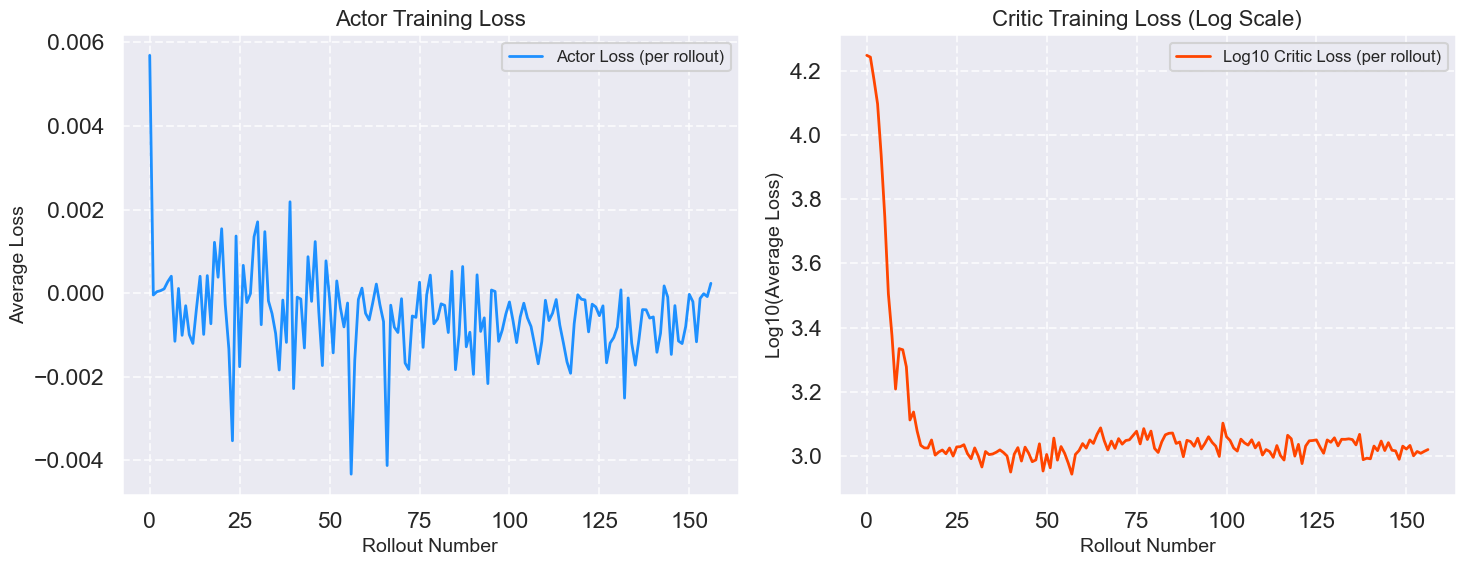

In [3]:
plt.figure(figsize=(15, 6)) # Adjusted figure size for two subplots

# First subplot: Actor Loss
plt.subplot(1, 2, 1) # (rows, columns, panel number)
plt.plot((history_actor_loss), label='Actor Loss (per rollout)', color='dodgerblue', linewidth=2)
plt.title('Actor Training Loss', fontsize=16)
plt.xlabel('Rollout Number', fontsize=14)
plt.ylabel('Average Loss', fontsize=14)
plt.legend(fontsize=12, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)

# Second subplot: Critic Loss
plt.subplot(1, 2, 2) # (rows, columns, panel number)
plt.plot(np.log10(history_critic_loss), label='Log10 Critic Loss (per rollout)', color='orangered', linewidth=2)
plt.title('Critic Training Loss (Log Scale)', fontsize=16)
plt.xlabel('Rollout Number', fontsize=14)
plt.ylabel('Log10(Average Loss)', fontsize=14)
plt.legend(fontsize=12, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout() # Adjusts plot to prevent labels from overlapping
plt.show()

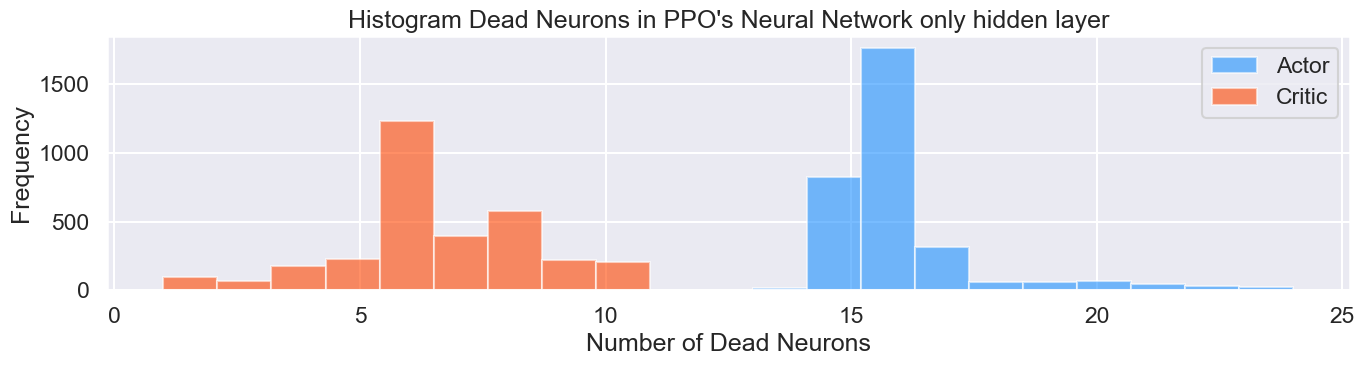

In [16]:
batch_obs, _ , _ , batch_rgts, _ , _ = model.rollout()

# Forward pass through actor and critic
actor_acts = model.actor.vizualisation(batch_obs)
actor_dead_neurons =  actor_acts == 0
number_actor_dead_neurons = actor_dead_neurons.sum(axis=1)

model.critic(batch_obs)
critic_acts = model.critic.vizualisation(batch_obs)
critic_dead_neurons = critic_acts == 0
number_critic_dead_neurons = critic_dead_neurons.sum(axis=1)


actor_counts = number_actor_dead_neurons.cpu().numpy()
critic_counts = number_critic_dead_neurons.cpu().numpy()

plt.figure(figsize=(14, 4))

plt.hist(actor_counts, bins=10, alpha=0.6, color='dodgerblue', label='Actor')
plt.hist(critic_counts, bins=10, alpha=0.6, color='orangered', label='Critic')

plt.title(f"Histogram Dead Neurons in PPO's Neural Network only hidden layer")
plt.xlabel("Number of Dead Neurons")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
# Multiple Batches for evaluation
num_eval_rollouts = 50
all_eval_rgts_list = []

for _ in range(num_eval_rollouts):
    _, _, _, batch_rgts, batch_lens, _ = model.rollout()
    all_eval_rgts_list.append(batch_rgts)

# Reformat matrix: [num_rollouts, trajectory length]
all_eval_rgts = torch.cat(all_eval_rgts_list, dim = 0)
matrix_rgts = all_eval_rgts.view(-1, batch_lens[0] * len(batch_lens)) 

# 
mean_rgts_trajectory = matrix_rgts.mean(dim=0)
std_rgts_trajectory  = matrix_rgts.std(dim=0)

mean_rgts = mean_rgts_trajectory.mean(dim=0)
std_rgts = matrix_rgts.mean(dim=1).std(dim=0)

print(f"Mean rtgs over all trajectories and rollouts: {mean_rgts:.2f}")
print(f"Standard deviation mean rtgs over {num_eval_rollouts} rollouts: {std_rgts:.2f}.")


Mean rtgs over all trajectories and rollouts: -128.87
Standard deviation mean rtgs over 50 rollouts: 5.34.


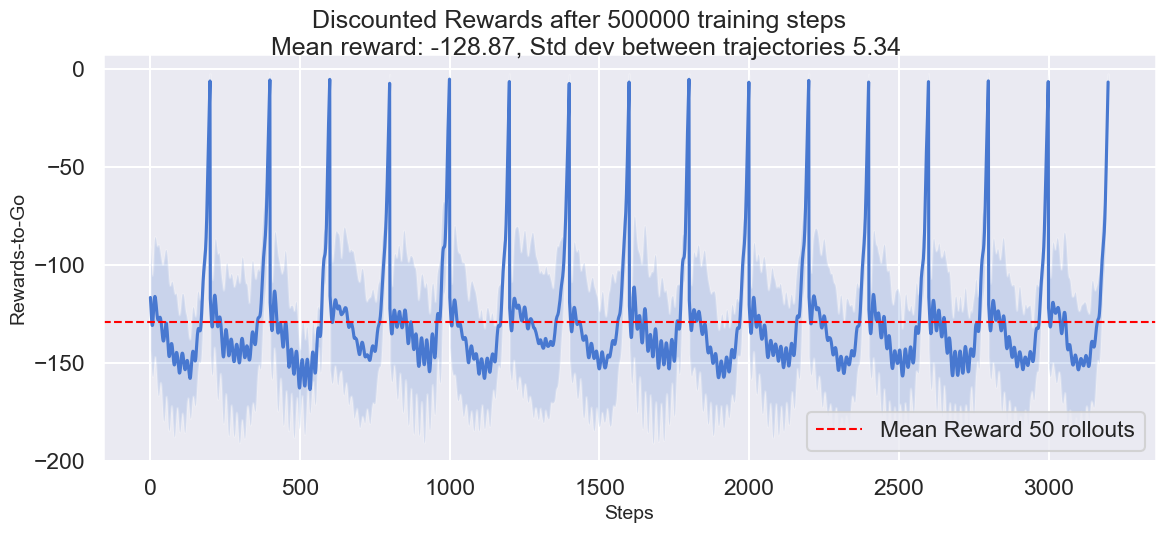

In [6]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=mean_rgts_trajectory)
plt.axhline(y = mean_rgts, color="red", linestyle = "--", linewidth = 1.5, label = f"Mean Reward {num_eval_rollouts} rollouts")
plt.fill_between(
    range(len(mean_rgts_trajectory)),
    mean_rgts_trajectory - std_rgts_trajectory, 
    mean_rgts_trajectory + std_rgts_trajectory, 
   alpha = 0.2)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("Rewards-to-Go", fontsize=14)
plt.suptitle(
    f"Discounted Rewards after {total_timesteps} training steps \n Mean reward: {mean_rgts:.2f}, Std dev between trajectories {std_rgts:.2f}",
    fontsize=18,
    y=0.9)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
